# IA307_TP2_Qingchen_YANG

# Installation

In [18]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [19]:
!pip install --upgrade git+git://github.com/frehseg/nvcc4jupyter.git

  Cloning git://github.com/frehseg/nvcc4jupyter.git to /tmp/pip-req-build-dus3392y
  Running command git clone -q git://github.com/frehseg/nvcc4jupyter.git /tmp/pip-req-build-dus3392y


In [20]:
%load_ext nvcc_plugin

The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


Based on the lecture at https://sites.google.com/site/frehseg/teaching/ia307

# Provided Code

## CUDA Utilities

In [33]:
%%writefile cuda_stuff.cuh
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>

#ifndef cuda_stuff_H
#define cuda_stuff_H

/* transform matrix index to vector offset
   Since CUDA uses column major, 
   nb_rows = number of rows */
#define IDX2C(i,j,nb_rows) (((j)*(nb_rows))+(i))
 
//MACRO TO DEBUGG CUDA FUNCTIONS
/** Error checking,
 *  taken from https://stackoverflow.com/questions/14038589/what-is-the-canonical-way-to-check-for-errors-using-the-cuda-runtime-api
 */
#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}
/** Error checking for use with CUDA Dynamic Parallelism */
/*
#define cdpErrchk(ans) { cdpAssert((ans), __FILE__, __LINE__); }
__device__ void cdpAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      printf("GPU kernel assert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) assert(0);
   }
}
*/
void device_synchronize();

#endif


Overwriting cuda_stuff.cuh


In [34]:
%%writefile cuda_stuff.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include "cuda_stuff.cuh"

void device_synchronize(){
    gpuErrchk(cudaDeviceSynchronize());
}

Overwriting cuda_stuff.cu


## fmatrix Matrix Tools

In [35]:
%%writefile fmatrix.cuh
#ifndef fmatrices_H
#define fmatrices_H
#include "cuda_stuff.cuh" // for IDX2C

typedef struct {
    float* data;
    int cols;
    int rows;
} fmatrix;

/* Access element (i,j) of matrix mat */
#define getfm(mat,i,j) (mat.data[IDX2C(i,j,mat.rows)])


int fmatrix_elements(fmatrix mat);
int fmatrix_size(fmatrix mat);
/** Assert that the matrix is coherent: all fields nonzero. */
void fmatrix_assert(fmatrix mat);

fmatrix fmatrix_create_on_host(int rows, int cols);
fmatrix fmatrix_create_on_device(int rows, int cols);
void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device);
void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device);
fmatrix fmatrix_copy_to_host(fmatrix mat_host);
fmatrix fmatrix_copy_to_device(fmatrix mat_host);
void fmatrix_free_on_host(fmatrix* mat);
void fmatrix_free_on_device(fmatrix* mat);

/** Create a matrix representing columns [a,b) of M. 
 *  Note that the new matrix points into the
 *  data of M. The data is not copied to a new location.
 */
fmatrix fmatrix_subcolumns(fmatrix M, int a, int b);

/** Print the first nb rows of the matrix mat
 *  on the host. 
 *  If nb<0, print all rows. 
 */
 __host__
 __device__
void fmatrix_print(fmatrix mat, int nb=-1);

/** Print the first nb rows of the matrix mat
 *  on the device. 
 *  If nb<0, print all rows. 
 *
 *  This version copies the matrix to host first.
 */
void fmatrix_device_print(fmatrix mat, int nb=-1);

#endif


Overwriting fmatrix.cuh


In [36]:
%%writefile fmatrix.cu
#include <assert.h>
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include "cuda_stuff.cuh"
#include "fmatrix.cuh"

int fmatrix_elements(fmatrix mat) {
     return mat.cols*mat.rows;
}

int fmatrix_size(fmatrix mat) {
     return fmatrix_elements(mat) * sizeof(mat.data[0]);
}

void fmatrix_assert(fmatrix mat) {
    assert(mat.data);
    assert(mat.cols);
    assert(mat.rows);
}

fmatrix fmatrix_create_on_host(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    mat.data = (float*)malloc(fmatrix_size(mat)); 
    assert(mat.data);
    return mat;
}

fmatrix fmatrix_create_on_device(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    gpuErrchk( 
        cudaMalloc((void **)&(mat.data), fmatrix_size(mat)) 
    );
    return mat;
}

void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk( 
        cudaMemcpy( mat_device.data, mat_host.data, 
                   fmatrix_size(mat_host), 
                   cudaMemcpyHostToDevice 
                   )
        );
}

void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy( mat_host.data, mat_device.data,  
                   fmatrix_size(mat_device), 
                   cudaMemcpyDeviceToHost 
                   )
        );
}

fmatrix fmatrix_copy_to_host(fmatrix mat_device) {
    fmatrix_assert(mat_device);
    fmatrix mat_host = fmatrix_create_on_host(mat_device.rows, mat_device.cols);
    fmatrix_data_to_host(mat_host,mat_device);
    return mat_host;
}

fmatrix fmatrix_copy_to_device(fmatrix mat_host) {
    fmatrix_assert(mat_host);
    fmatrix mat_device = fmatrix_create_on_device(mat_host.rows, mat_host.cols);
    fmatrix_data_to_device(mat_host,mat_device);
    return mat_device;
}

void fmatrix_free_on_host(fmatrix* mat) {
    fmatrix_assert(*mat);  
  free(mat->data);
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

void fmatrix_free_on_device(fmatrix* mat) {
    fmatrix_assert(*mat);  
  gpuErrchk(cudaFree(mat->data));
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

fmatrix fmatrix_subcolumns(fmatrix M, int a, int b) {
    fmatrix_assert(M);  
    fmatrix A = { 
        .data = &getfm(M,0,a),  
        .cols = b-a,
        .rows = M.rows 
    };
    fmatrix_assert(A);  
    return A;
}


__host__
__device__
void fmatrix_print(fmatrix mat, int nb){
    if (nb<0 || nb > mat.rows) {
        nb = mat.rows;
    }
    printf("[\n");
    for (int i = 0 ; i < nb; i++){
      for (int j = 0 ; j<mat.cols; j++){
        printf("%f", getfm(mat,i,j));
        if (j+1<mat.cols) {
          printf(",\t");
        }
      }
      if (i+1<nb) {
        printf(";\n");
      }
    }
    if (nb < mat.rows) {
      printf("\n...\n");
    }
  printf("\n]\n");
}

void fmatrix_device_print(fmatrix mat, int nb){
   // allocate copy
   fmatrix tmp = fmatrix_copy_to_host(mat);
   fmatrix_print(tmp,nb);
   fmatrix_free_on_host(&tmp);
}



Overwriting fmatrix.cu


## Data I/O

In [37]:
%%writefile read_csv.cuh
#include <cuda_runtime.h>
#ifndef read_csv_H
#define read_csv_H

void read_csv(const char* filename, float* data_array,int nbrow,int nbcol);

#endif

Overwriting read_csv.cuh


In [38]:
%%writefile read_csv.cu


#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

#include "read_csv.cuh"
#include "cuda_stuff.cuh" // for matrix indexing

using namespace std;

/////////////////////////////////////////////////////////
// Functions for reading the dataset from a file
/////////////////////////////////////////////////////////

/* Read a csv file with a given number of rows and columns */
void read_csv(const char* filename, float* data_array,int nbrow,int nbcol) {
  string row_as_string;
  string value;
  double ioTemp;
  ifstream infile;
  infile.open(filename, ifstream::in);
  int row_count = 0;
	if (infile.is_open())
  {
      // read the headers (and discard)
			getline(infile, row_as_string, '\n');
      cout << "headers: " << row_as_string << "!" << std::endl;
      for(int i = 0; i < nbrow; i++){
  			getline(infile, row_as_string, '\n');
        // cout << "read line " << row_as_string << "!" << std::endl;
				istringstream line_stream(row_as_string);
			  for(int j = 0; j < nbcol; j++){
          getline(line_stream, value, ',');
					ioTemp = strtod(value.c_str(), NULL); 
          // cout << "("<<i<<","<<j<<") = "<< ioTemp << std::endl;

					data_array[IDX2C(i,j,nbrow)] = ioTemp;

				}
        ++row_count;
			}
		infile.close();
    cout << "Read " << row_count << " rows." << std::endl;
	}
	else cout << "Cannot open file." << endl;
}



Overwriting read_csv.cu


In [39]:
%%writefile preprocess_data.cuh

#include <cuda_runtime.h>
#ifndef preprocess_data_H
#define preprocess_data_H

void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels );

#endif

Overwriting preprocess_data.cuh


In [40]:
%%writefile preprocess_data.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "preprocess_data.cuh"

using namespace std;

/* transform matrix index to vector offset
   Since CUDA uses column major, 
   ld = number of rows 
   Example of use: a[IDX2C(0, 1, 50)] */
#define IDX2C(i,j,ld) (((j)*(ld))+(i))

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)
/////////////////////////////////////////////////////////
// Functions for preprocessing the data set
/////////////////////////////////////////////////////////

/* Split data into inputs and labels. Allocated memory for inputs and labels.
   Since cuBLAS is column major, each input is in a column.
   We also add 1.0 as first element to each input vector.
*/
void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels ) {
    // The inputs are the first nbrows-1 columns.
    // The labels are the last column (index nbrows-1), booleanized
    // by the condition >= above_threshold
    *input_array = (float *)malloc(nbrows * nb_inputs * sizeof(float));    
    *label_array = (float *)malloc(nbrows * nb_labels * sizeof(float));    
    //cout << &input_array << " and "<< &label_array << " data " << data_array << std::endl;
    cout << "Allocated memory for inputs: " << nbrows << " rows, "<< nb_inputs << " columns." << std::endl;
    cout << "Allocated memory for labels: " << nbrows << " rows, "<< nb_labels << " columns." << std::endl;

    // Copy the data to X
    for(int i = 0; i < nbrows; i++){
      // Set the first element of each x to 1  
      (*input_array)[IDX2C(0,i,nb_inputs)] = 1.0;
      // Copy the rest of x
			for(int j = 1; j < nb_inputs; j++){
				(*input_array)[IDX2C(j,i,nb_inputs)] = data_array[IDX2C(i,j-1,nbrows)];
			}
      float median_house_value = data_array[IDX2C(i,nbcols-1,nbrows)];
      (*label_array)[IDX2C(0,i,nb_labels)] = 0.0;
      (*label_array)[IDX2C(1,i,nb_labels)] = 0.0;
      if (median_house_value >= above_threshold) {
        (*label_array)[IDX2C(0,i,nb_labels)] = 1.0;
      } else {
        (*label_array)[IDX2C(1,i,nb_labels)] = 1.0;        
      }
		}    
    
    // Show some entries for double checking
    cout << "Inputs (first "<<print_rows<<"):" << std::endl;
	  for(int j = 0; j < nb_inputs; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*input_array)[IDX2C(j,i,nb_inputs)] << "\t";
			}
      cout << "\n";
		}
    cout << "Labels (first "<<print_rows<<"):" << std::endl;
    for(int j = 0; j < nb_labels; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*label_array)[IDX2C(j,i,nb_labels)] << "\t";
			}
      cout << "\n";
		}
}

Overwriting preprocess_data.cu


# Code That You Write

## Classifier Math

In [41]:
%%writefile classifier_math.cuh
#ifndef classifier_math_H
#define classifier_math_H

#include "fmatrix.cuh"

/** Returns a random float between min and max (including). */
float float_rand( float min, float max );

/** Initialize W with Xavier's method,
 *  scaled by a. */
void xavier_weight_init(float a, fmatrix W);

/** Compute the softmax for each column of Z and store in P **/
void softmax_col(fmatrix P,fmatrix Z); 

///////////////////////////////////
// TO BE COMPLETED
// ... add your matrix math here
///////////////////////////////////


//compute the transpose of P and store it in Z
void fmatrix_transpose(fmatrix P, fmatrix Z);


void fmatrix_add(fmatrix P,float a,fmatrix Y);

void fmatrix_mult(fmatrix A, float f, fmatrix B, fmatrix C);
void fmatrix_compute(fmatrix P, fmatrix mu, fmatrix sigma);
void fmatrix_normalize(fmatrix P, fmatrix mu, fmatrix sigma);

#endif

Overwriting classifier_math.cuh


In [42]:
%%writefile classifier_math.cu
#include "classifier_math.cuh"
#include "cuda_stuff.cuh"
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include <math.h>
#include <assert.h>
#define THREADS_PER_BLOCK 1024
#include "fmatrix.cuh"

/////////////////////////////////////////////////////////
// Auxiliary function
/////////////////////////////////////////////////////////
// generate random numbers in interval [min,max]
float float_rand( float min, float max )
{
    float scale = rand() / (float) RAND_MAX; /* [0, 1.0] */
    return min + scale * ( max - min );      /* [min, max] */
}

void xavier_weight_init(float a, fmatrix W){
    for (int j = 0; j < W.rows  ; ++j) {
      for (int i = 0; i < W.cols  ; ++i) {
          getfm(W,j,i) = a * (1.0/sqrt(W.cols+W.rows)) * float_rand(-1.0,1.0);
      }
    }
}


__global__ 
void fmatrix_stable_softmax_kernel(fmatrix P, fmatrix Z) {
    
    __shared__ float sum[5000];
    __shared__ float max[5000];

    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / Z.rows;
    int i = idx % Z.rows;
    if (i < Z.rows && j < Z.cols ){
        if (i == 0){
            max[j] = getfm(Z,0,j);
            for (int k = 0; k < Z.rows; ++k) {
                if (getfm(Z,k,j) > max[j]) max[j] = getfm(Z,k,j);
            }
            sum[j] = 0;
            for (int k = 0; k < Z.rows; ++k) {
                sum[j] += exp(getfm(Z,k,j) - max[j]);
            }
        }
    }
    __syncthreads();


    if (i < Z.rows && j < Z.cols ){
        getfm(P,i,j) = exp(getfm(Z,i,j) - max[j]) / sum[j];
    }
}


void softmax_col(fmatrix P,fmatrix Z) {
    assert(P.cols==Z.cols);
    assert(P.rows==Z.rows);
    
    ///////////////////////////////////
    // TO BE COMPLETED
    // ... compute the softmax here ...
    ///////////////////////////////////

    fmatrix_assert(P);
    fmatrix_assert(Z);
    int threadsPerBlock = fmatrix_elements(Z);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_stable_softmax_kernel<<< blocksPerGrid, threadsPerBlock >>>(P, Z);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
}


__global__ 
void fmatrix_transpose_kernel(fmatrix P, fmatrix Z) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / P.rows;
    int i = idx % P.rows;
    getfm(Z,j,i) = getfm(P,i,j);
    __syncthreads(); 
}

void fmatrix_transpose(fmatrix P, fmatrix Z) {
    fmatrix_assert(P);
    fmatrix_assert(Z);
    int threadsPerBlock = fmatrix_elements(Z);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_transpose_kernel<<< blocksPerGrid, threadsPerBlock >>>(P, Z);
    gpuErrchk( cudaPeekAtLastError() );
}


__global__ 
void fmatrix_add_kernel(fmatrix P,float a,fmatrix Y) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / P.rows;
    int i = idx % P.rows;
    if (i < P.rows && j < P.cols ){
        getfm(P,i,j) += a*getfm(Y,i,j);
    }
}

/** Compute P = P + a*Y */
void fmatrix_add(fmatrix P,float a,fmatrix Y) {
    fmatrix_assert(P);
    fmatrix_assert(Y);
    int threadsPerBlock = fmatrix_elements(P);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_add_kernel<<< blocksPerGrid, threadsPerBlock >>>(P,a,Y);
    gpuErrchk( cudaPeekAtLastError() );
}

__global__
void fmatrix_multiplication_kernel(fmatrix A, float f, fmatrix B, fmatrix C) {
    // Each thread multiplies one row of B with one column of C
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / A.rows;
    int i = idx % A.rows;
    if (i < A.rows && j < A.cols ){
        getfm(A,i,j) = 0.0;
        for (int k = 0; k < B.cols; ++k) {
          getfm(A,i,j) += f*getfm(B,i,k)*getfm(C,k,j);
        }
    }
}

/* Compute A = f*B*C */
void fmatrix_mult(fmatrix A, float f, fmatrix B, fmatrix C) {
    // First let's check for errors in the argument M.
    // This can help a LOT when debugging.
    // A,B,C need to have nonzero pointers etc.
    // fmatrix_assert(A);
    // fmatrix_assert(B);
    // fmatrix_assert(C);
    
    // take one thread per element, and distribute
    // over as many blocks as necessary given
    // the hardware limit on the number of threads per block
    int threadsPerBlock = fmatrix_elements(A);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_multiplication_kernel<<< blocksPerGrid, threadsPerBlock >>>(A,f,B,C);
    // check for errors
    gpuErrchk( cudaPeekAtLastError() );
    // wait for the kernel to finish
    device_synchronize();
}


__global__ 
void fmatrix_compute_kernel(fmatrix P, fmatrix M_mu, fmatrix M_sigma) {
    __shared__ float sum[5000];
    __shared__ float sigma[5000];

    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / P.rows;
    int i = idx % P.rows;
    if (i < P.rows && j < P.cols ){
        if (j == 0){
            for (int k = 0; k < P.cols; ++k) {
              sum[i] += getfm(P,i,k);
            }   
        }
        __syncthreads(); 

        if (j == 0){
            float mu = sum[i] / P.cols;
            float sum_square = 0;     
            for (int k = 0; k < P.cols; ++k) {
              sum_square += pow(getfm(P,i,k) - mu, 2);
            }     
            sigma[i] = sqrt(sum_square / P.cols);
        }
        __syncthreads(); 
        if (i < M_mu.rows && j < M_mu.cols){
            getfm(M_mu,i,j) = sum[i] / P.cols;
            getfm(M_sigma,i,j) = sigma[i];
            
        }
        

    }
}

void fmatrix_compute(fmatrix P, fmatrix mu, fmatrix sigma) {
    int threadsPerBlock = fmatrix_elements(P);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_compute_kernel<<< blocksPerGrid, threadsPerBlock >>>(P, mu, sigma);
    gpuErrchk( cudaPeekAtLastError() );
}


__global__ 
void fmatrix_normalize_kernel(fmatrix P, fmatrix M_mu, fmatrix M_sigma) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / P.rows;
    int i = idx % P.rows;
    if (i < P.rows && j < P.cols ){
        getfm(P, i, j) = (getfm(P, i, j) - getfm(M_mu, i, 0)) / (getfm(M_sigma, i, 0));
    }
}

void fmatrix_normalize(fmatrix P, fmatrix mu, fmatrix sigma) {
    int threadsPerBlock = fmatrix_elements(P);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_normalize_kernel<<< blocksPerGrid, threadsPerBlock >>>(P, mu, sigma);
    gpuErrchk( cudaPeekAtLastError() );
}


Overwriting classifier_math.cu


## Evaluating Accuracy


In [43]:
%%writefile evaluate_accuracy.cuh

/** Evaluate the accuracy of a linear classifier with D x M weight
 *  matrix W, using D x N input data X and M x N output labels Y.
 *  Z is a temporary matrix with dimensions M x N,
 *  which must be previously allocated.
 */
float evaluate_accuracy(fmatrix d_W,fmatrix d_X,fmatrix d_Y,fmatrix d_Z);

/** Compute the logloss given M x N matrices of 
 *  probabilities P and output labels Y
 *  and stores it in J.
 *  J is a matrix with dimensions 1 x 1,
 *  which must be previously allocated.
 *  logloss = sum_j -Y(j,k)*log(P(j,k))
 */
float evaluate_logloss(fmatrix d_P,fmatrix d_Y);

Overwriting evaluate_accuracy.cuh


In [44]:
%%writefile evaluate_accuracy.cu
#include "fmatrix.cuh"
#include "classifier_math.cuh"
#include <assert.h>

#define THREADS_PER_BLOCK 1024

__global__ 
void evaluate_accuracy_kernel(fmatrix d_Y,fmatrix d_Z,int* count) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    if (idx < d_Z.cols){
        float z_max = getfm(d_Z,0,idx);
        int i_max = 0;
        for (int i = 1; i < d_Z.rows; ++i) {
          if (getfm(d_Z,i,idx)>z_max) {
                z_max = getfm(d_Z,i,idx);
                i_max = i;
          }
        }
      if (getfm(d_Y,i_max,idx)>=0.5f) {
          atomicAdd(count,1);
      }
    }    
}

float evaluate_accuracy(fmatrix d_W,fmatrix d_X,fmatrix d_Y,fmatrix d_Z) {
    assert(d_Y.cols == d_Z.cols);
    assert(d_Y.rows == d_Z.rows);

  //////////////////////////////////////////
  // 1. compute Z = W^T X
  // --> each column of Z corresponds to one input
  //////////////////////////////////////////

  /*********************************
  / TO BE COMPLETED
  / ... compute Z = W^T X here ...
  **********************************/


  fmatrix d_W_T = fmatrix_create_on_device(d_W.cols,d_W.rows);
  fmatrix_transpose(d_W, d_W_T);
  fmatrix_mult(d_Z, 1, d_W_T, d_X);
  fmatrix_free_on_device(&d_W_T);


  //////////////////////////////////////////
  // 2. For each column z of Z, 
  // find argmax_k z_k
  //////////////////////////////////////////

  int true_class = 0;

  int* d_count = 0;
  gpuErrchk(cudaMalloc((void **)&d_count, sizeof(int)));
  gpuErrchk( 
        cudaMemcpy( d_count, &true_class, sizeof(int), cudaMemcpyHostToDevice )
  );

    int threadsPerBlock = d_Z.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    evaluate_accuracy_kernel<<< blocksPerGrid, threadsPerBlock >>>(d_Y,d_Z,d_count);
    device_synchronize();
    gpuErrchk( cudaPeekAtLastError() );

  gpuErrchk(
          cudaMemcpy(&true_class, d_count, sizeof(int), cudaMemcpyDeviceToHost )
  );

  //printf("Correct results: %d out of %d\n",true_class,nb_tested);
  //printf("Accuracy: %f\n",(float)true_class/(float)nb_tested);
  return (float)true_class/(float)d_Z.cols;
}


__global__
void evaluate_logloss_kernel(fmatrix d_P,fmatrix d_Y, float* dev_a){
    /*__shared__ float sum;
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / d_P.rows;
    int i = idx % d_P.rows;

    if (i==0 && j==0) sum = 0;
    __syncthreads();

    if (i < d_P.rows && j < d_P.cols ){
        sum = sum - getfm(d_Y,i,j) * log10(getfm(d_P,i,j));
    }
    __syncthreads();
    *dev_a = sum;
    */

    __shared__ float sum;
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / d_P.rows;
    int i = idx % d_P.rows;

    if (i==0 && j==0){
        sum = 0;
        for (int k=0; k<d_P.rows; k++){
            for (int l=0; l<d_P.cols; l++){
                sum = sum - getfm(d_Y,k,l) * log10(getfm(d_P,k,l));
            }
        }
    } 
    __syncthreads();
    *dev_a = sum;
}


float evaluate_logloss(fmatrix d_P,fmatrix d_Y) {
    assert(d_Y.cols == d_P.cols);
    assert(d_Y.rows == d_P.rows);

  float J = 0.0;

    ///////////////////////////////////
    // TO BE COMPLETED
    // ... compute the logloss here ...
    ///////////////////////////////////

    int threadsPerBlock = fmatrix_elements(d_P);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
     float *dev_a;
     float a = 0;
     cudaMalloc((void**)&dev_a, sizeof(float));
     cudaMemcpy(dev_a, &a, sizeof(float), cudaMemcpyHostToDevice);

    evaluate_logloss_kernel<<< blocksPerGrid, threadsPerBlock >>>(d_P, d_Y, dev_a);

    cudaMemcpy(&a, dev_a, sizeof(float), cudaMemcpyDeviceToHost);
    cudaFree(dev_a);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

  return a;
}




Overwriting evaluate_accuracy.cu


## Linear Classifier

In [114]:
%%writefile linear_classification.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)


/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv)
{
    
    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train = 5000; //12000; // points for training (Google: 12000)
    size_t N_test =3000;// 5000; // points for validation (Google: 5000)
    size_t N = N_train;
    size_t Nall = N_train+N_test;
    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall,data_columns);
    read_csv("sample_data/california_housing_train.csv",alldata.data,Nall,data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns-1+1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D,Nall);
    fmatrix Yall = fmatrix_create_on_host(M,Nall);
    get_inputs_and_labels(alldata.data,&Xall.data,&Yall.data,Nall,data_columns,D,M);
    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////
     
    // Logfile
    FILE* fp = fopen("log.txt", "w");
    
    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    int nb_iter = 1200;           // defeault: 10;
    int periods = nb_iter;      // reporting period
    int batch_size = N;         // defeault: N;
    float learning_rate = 1e-7; // default: 1e-7
 
    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall,0,N);
    fmatrix h_Y = fmatrix_subcolumns(Yall,0,N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall,N,Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall,N,Nall);
    fmatrix h_W = fmatrix_create_on_host(D,M);
    fmatrix h_J = fmatrix_create_on_host(1,1);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix 
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1.0,h_W);
 
    //////////////////////////////
    // Copy data to device      //
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);
 
    /////////////////////////////////////////
    // Create auxiliary matrices on device //
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M,batch_size);
    fmatrix d_P = fmatrix_create_on_device(M,batch_size);
    fmatrix d_G = fmatrix_create_on_device(D,M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M,d_Xtest.cols);

    /////////////////////////////////////////////////////////
    // Batch Gradient Descent
    /////////////////////////////////////////////////////////
    //fmatrix_device_print(d_X);
    //fmatrix_device_print(d_W);
 
     /* Evaluate the accuracy */
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    float J = 0;
 
    clock_t tstart_total, tend;
    tstart_total = clock();
 
    int batch_pointer = 0;

    fmatrix d_X_T = fmatrix_create_on_device(d_X.cols, d_X.rows);
    fmatrix_transpose(d_X, d_X_T);
    fmatrix mu = fmatrix_create_on_device(d_X_T.rows,1);
    fmatrix sigma = fmatrix_create_on_device(d_X_T.rows,1);
    fmatrix_compute(d_X_T, mu, sigma);
    fmatrix_normalize(d_X_T, mu, sigma);
    fmatrix_transpose(d_X_T, d_X);

 
    fmatrix_free_on_device(&mu);
    fmatrix_free_on_device(&sigma);
    fmatrix_free_on_device(&d_X_T);


    for (int i = 0; i < nb_iter; ++i ) {

      ////////////////////////////////
      // compute Z = W^T X
      // --> each column z of Z corresponds to one column x of X
      ////////////////////////////////
      
      ///////////////////////////////////
      // TO BE COMPLETED
      ///////////////////////////////////
      

      fmatrix d_W_T = fmatrix_create_on_device(d_W.cols, d_W.rows);
      fmatrix_transpose(d_W, d_W_T);
      fmatrix_mult(d_Z, 1, d_W_T, d_X);
       fmatrix_free_on_device(&d_W_T);

      ////////////////////////////////
      // For each column z of Z, compute activation p(z);
      // then update W
      ////////////////////////////////

      // compute softmax per column of Z and store in Z

    ///////////////////////////////////
    // TO BE COMPLETED
    ///////////////////////////////////

    softmax_col(d_Z, d_Z);
    

    d_P = d_Z;

    

      // evaluate logloss (for reporting only)

    ///////////////////////////////////
    // TO BE COMPLETED
    ///////////////////////////////////

    J = evaluate_logloss(d_P, d_Y)/N_test;

      
      // Q:=P-Y
      // compute gradient G = XQ^T
      // ... possibly work with G here ...
      // update weights W = W - learning_rate*G

    ///////////////////////////////////
    // TO BE COMPLETED
    ///////////////////////////////////


      fmatrix d_Q =  fmatrix_copy_to_device(d_P);
      fmatrix_add(d_Q, -1, d_Y);
      

      
      fmatrix d_Q_T = fmatrix_create_on_device(d_P.cols,d_P.rows);
      fmatrix_transpose(d_Q, d_Q_T);

      fmatrix_mult(d_G, 1, d_X, d_Q_T);
      fmatrix_free_on_device(&d_Q_T);
      fmatrix_free_on_device(&d_Q);
      
      float learning_rate_minus = 0 - learning_rate;
      fmatrix_add(d_W, -0.0001, d_G);

      //printf("W:\n");fmatrix_device_print(d_W);
      
      ////////////////////////////////
      // For reporting, compute logloss and accuracy
      ////////////////////////////////
      if (i%(100)==0) {
        float accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
        printf("iter: %d, logloss: %f, accuracy: %f\n",i,J, accuracy);
        fprintf(fp, "%f,%f\n", J, accuracy);
      }

    }
    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;
    printf("Duration (s): %f\n",duration);
    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since 
     *  they all point to Xall 
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);
 
    // Close log file
    fclose(fp);
}

Overwriting linear_classification.cu


# Compiling

In [115]:
!nvcc -arch=sm_35 -Wno-deprecated-gpu-targets -I /usr/local/cuda/samples/common/inc/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

linear_classification.cu(74): warning: variable "periods" was declared but never referenced

linear_classification.cu(130): warning: variable "batch_pointer" was declared but never referenced

evaluate_accuracy.cu(118): warning: variable "J" was declared but never referenced



# Experiments

In [116]:
%%time
!./a.out 


headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 8000 rows.
Allocated memory for inputs: 8000 rows, 9 columns.
Allocated memory for labels: 8000 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	-114.58	-114.59	-114.59	-114.6	
34.19	34.4	33.69	33.64	33.57	33.63	33.61	34.83	33.61	34.83	
15	19	17	14	20	29	25	41	34	46	
5612	7650	720	1501	1454	1387	2907	812	4789	1497	
1283	1901	174	337	326	236	680	168	1175	309	
1015	1129	333	515	624	671	1841	375	3134	787	
472	463	117	226	262	239	633	158	1056	271	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	2.6768	1.7083	2.1782	2.1908	
Labels (first 10):
0	0	0	0	0	0	0	0	0	0	
1	1	1	1	1	1	1	1	1	1	
initial accuracy: 0.726333
iter: 0, logloss: 0.390491, accuracy: 0.726333
iter: 100, logloss: 0.284045, accuracy: 0.738000
iter: 200, logloss: 0.276143, accuracy: 0.748667
iter: 300, logloss: 0.271930, accuracy: 0.

Let's plot the logloss and accuracy.

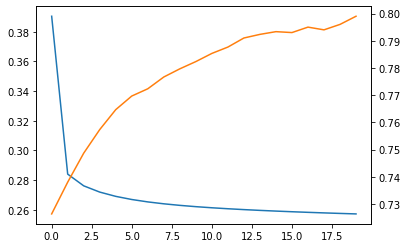

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('log.txt',sep=',',header=None)
fig,ax = plt.subplots()
ax.plot(data[0],label="logloss")
ax2=ax.twinx()
ax2.plot([], [])
ax2.plot(data[1],label="accuracy")
plt.show()

## Step 2: Mini-Batch 

In [156]:
%%writefile linear_classification.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)


/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv)
{
    
    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train = 12000; //12000; // points for training (Google: 12000)
    size_t N_test =5000;// 5000; // points for validation (Google: 5000)
    size_t N = N_train;
    size_t Nall = N_train+N_test;
    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall,data_columns);
    read_csv("sample_data/california_housing_train.csv",alldata.data,Nall,data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns-1+1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D,Nall);
    fmatrix Yall = fmatrix_create_on_host(M,Nall);
    get_inputs_and_labels(alldata.data,&Xall.data,&Yall.data,Nall,data_columns,D,M);
    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////
     
    // Logfile
    FILE* fp = fopen("log.txt", "w");
    
    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    int nb_iter = 100;           // defeault: 10;
    int periods = nb_iter;      // reporting period
    int batch_size = 100;         // defeault: N;
    float learning_rate = 0.005; // default: 1e-7
 
    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall,0,N);
    fmatrix h_Y = fmatrix_subcolumns(Yall,0,N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall,N,Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall,N,Nall);
    fmatrix h_W = fmatrix_create_on_host(D,M);
    fmatrix h_J = fmatrix_create_on_host(1,1);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix 
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1.0,h_W);
 
    //////////////////////////////
    // Copy data to device      //
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);
 
    /////////////////////////////////////////
    // Create auxiliary matrices on device //
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M,batch_size);
    fmatrix d_P = fmatrix_create_on_device(M,batch_size);
    fmatrix d_G = fmatrix_create_on_device(D,M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M,d_Xtest.cols);

    /////////////////////////////////////////////////////////
    // Batch Gradient Descent
    /////////////////////////////////////////////////////////
    //fmatrix_device_print(d_X);
    //fmatrix_device_print(d_W);
 
     /* Evaluate the accuracy */
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    float J = 0;
 
    clock_t tstart_total, tend;
    tstart_total = clock();
 
    int batch_pointer = 0;


    fmatrix d_X_1[N_train/batch_size];
    fmatrix d_Y_1[N_train/batch_size];
    for (int i = 0; i<N_train/batch_size; i++){
      d_X_1[i] = fmatrix_subcolumns(d_X,i*(batch_size),(i+1)*(batch_size));
      d_Y_1[i] = fmatrix_subcolumns(d_Y,i*(batch_size),(i+1)*(batch_size));
      fmatrix d_X_T_1 = fmatrix_create_on_device(d_X_1[i].cols, d_X_1[i].rows);
      fmatrix_transpose(d_X_1[i], d_X_T_1);
      fmatrix mu = fmatrix_create_on_device(d_X_T_1.rows,1);
      fmatrix sigma = fmatrix_create_on_device(d_X_T_1.rows,1);
      fmatrix_compute(d_X_T_1, mu, sigma);
      fmatrix_normalize(d_X_T_1, mu, sigma);
      fmatrix_transpose(d_X_T_1, d_X_1[i]);
      fmatrix_free_on_device(&mu);
      fmatrix_free_on_device(&sigma);
      fmatrix_free_on_device(&d_X_T_1);
    }

    for (int i = 0; i < nb_iter; ++i ) {
        for(int k = 0; k < N_train/batch_size; ++k){
            
      ////////////////////////////////
      // compute Z = W^T X
      // --> each column z of Z corresponds to one column x of X
      ////////////////////////////////
      
      ///////////////////////////////////
      // TO BE COMPLETED
      ///////////////////////////////////

          fmatrix d_W_T = fmatrix_create_on_device(d_W.cols, d_W.rows);
          fmatrix_transpose(d_W, d_W_T);
          fmatrix_mult(d_Z, 1, d_W_T, d_X_1[k]);
          fmatrix_free_on_device(&d_W_T);

      ////////////////////////////////
      // For each column z of Z, compute activation p(z);
      // then update W
      ////////////////////////////////

      // compute softmax per column of Z and store in Z

    ///////////////////////////////////
    // TO BE COMPLETED
    ///////////////////////////////////

          softmax_col(d_Z, d_Z);
          d_P = d_Z;

      // evaluate logloss (for reporting only)

    ///////////////////////////////////
    // TO BE COMPLETED
    ///////////////////////////////////

          if (k == 0) J = 0;
          else J += evaluate_logloss(d_P, d_Y_1[k]);
          if (k == N_train/batch_size - 1) J /= N_train;
          


      // Q:=P-Y
      // compute gradient G = XQ^T
      // ... possibly work with G here ...
      // update weights W = W - learning_rate*G

    ///////////////////////////////////
    // TO BE COMPLETED
    ///////////////////////////////////


          fmatrix d_Q =  fmatrix_copy_to_device(d_P);
          fmatrix_add(d_Q, -1, d_Y_1[k]);
      
          fmatrix d_Q_T = fmatrix_create_on_device(d_P.cols,d_P.rows);
          fmatrix_transpose(d_Q, d_Q_T);

          fmatrix_mult(d_G, 1, d_X_1[k], d_Q_T);
          fmatrix_free_on_device(&d_Q_T);
          fmatrix_free_on_device(&d_Q);
      
          float learning_rate_minus = 0 - learning_rate;
          fmatrix_add(d_W, learning_rate_minus, d_G);

      //printf("W:\n");fmatrix_device_print(d_W);
      
      ////////////////////////////////
      // For reporting, compute logloss and accuracy
      ////////////////////////////////
          if (k == N_train/batch_size - 1) {
            float accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
            printf("epoch: %d, logloss: %f, accuracy: %f\n",i,J, accuracy);
            fprintf(fp, "%f,%f\n", J, accuracy);
          }
        }
    }
    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;
    printf("Duration (s): %f\n",duration);
    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since 
     *  they all point to Xall 
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);
 
    // Close log file
    fclose(fp);
}

Overwriting linear_classification.cu


In [157]:
!nvcc -arch=sm_35 -Wno-deprecated-gpu-targets -I /usr/local/cuda/samples/common/inc/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

linear_classification.cu(74): warning: variable "periods" was declared but never referenced

linear_classification.cu(130): warning: variable "batch_pointer" was declared but never referenced

evaluate_accuracy.cu(118): warning: variable "J" was declared but never referenced



In [158]:
%%time
!./a.out 

headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 17000 rows.
Allocated memory for inputs: 17000 rows, 9 columns.
Allocated memory for labels: 17000 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	-114.58	-114.59	-114.59	-114.6	
34.19	34.4	33.69	33.64	33.57	33.63	33.61	34.83	33.61	34.83	
15	19	17	14	20	29	25	41	34	46	
5612	7650	720	1501	1454	1387	2907	812	4789	1497	
1283	1901	174	337	326	236	680	168	1175	309	
1015	1129	333	515	624	671	1841	375	3134	787	
472	463	117	226	262	239	633	158	1056	271	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	2.6768	1.7083	2.1782	2.1908	
Labels (first 10):
0	0	0	0	0	0	0	0	0	0	
1	1	1	1	1	1	1	1	1	1	
initial accuracy: 0.660200
epoch: 0, logloss: 0.204232, accuracy: 0.660000
epoch: 1, logloss: 0.203022, accuracy: 0.367000
epoch: 2, logloss: 0.202438, accuracy: 0.392800
epoch: 3, logloss: 0.201989, accuracy: 0

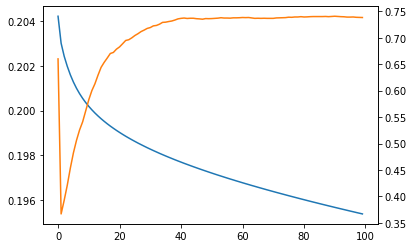

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('log.txt',sep=',',header=None)
fig,ax = plt.subplots()
ax.plot(data[0],label="logloss")
ax2=ax.twinx()
ax2.plot([], [])
ax2.plot(data[1],label="accuracy")
plt.show()

## Conclusion

Step 1 without mini-Batch: in the softmax and the normalization we use \_shared_ float sum[5000] etc, donc without mini-batch we can't use the entire dataset wich contains N_train = 12000 for training. So we choose the size of N_train = 5000 and size of N_test = 3000, and we plot the loss and accuracy during 1200 iters. After 1200 iters, the final accuracy is 0.791, Wall time: 2.72 s. If we use 2000 iters, the final accuracy is 0.801, Wall time: 4.33 s. 
<br>
<br>
Step 2 with mini-Batch: we use N_train = 12000 for training and  N_test = 5000 for testing. We plot the loss and accuracy during 100 epochs. after 100 epochs, the final accuracy is 0.738, Wall time: 2.72 s. If we use 200 epochs, the final accuracy is 0.745, Wall time: 1.72 s. 
<br>parameters: learning rate = 0.005, batch size = 100


